# 최근접 이웃(K-Nearest Neighbor) -KNN

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 인스턴스베이스 모델, 논파라미터 모델 이라고도 불림
* 분류와 회귀 모두 지원

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

In [2]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [46]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

In [22]:
from sklearn.datasets import load_iris,load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier

In [14]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted


class GaussRankScaler(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        epsilon=1e-4,
        copy=True,
        n_jobs=None,
        interp_kind="linear",
        interp_copy=False,
    ):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = "extrapolate"
        self.n_jobs = n_jobs
        self.bound = 1.0 - self.epsilon

    def fit(self, X, y=None):

        X = check_array(
            X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True
        )

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit)(x) for x in X.T
        )
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        factor = np.max(rank) / 2.0 * self.bound
        scaled_rank = np.clip(rank / factor - self.bound, -self.bound, self.bound)
        return interp1d(
            x,
            scaled_rank,
            kind=self.interp_kind,
            copy=self.interp_copy,
            fill_value=self.fill_value,
        )

    def transform(self, X, copy=None):

        check_is_fitted(self, "interp_func_")

        copy = copy if copy is not None else self.copy
        X = check_array(
            X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True
        )

        X = np.array(
            Parallel(n_jobs=self.n_jobs)(
                delayed(self._transform)(i, x) for i, x in enumerate(X.T)
            )
        ).T
        return X

    def _transform(self, i, x):
        clipped = np.clip(self.interp_func_[i](x), -self.bound, self.bound)
        return erfinv(clipped)

    def inverse_transform(self, X, copy=None):
        check_is_fitted(self, "interp_func_")

        copy = copy if copy is not None else self.copy
        X = check_array(
            X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True
        )

        X = np.array(
            Parallel(n_jobs=self.n_jobs)(
                delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T)
            )
        ).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(
            self.interp_func_[i].y,
            self.interp_func_[i].x,
            kind=self.interp_kind,
            copy=self.interp_copy,
            fill_value=self.fill_value,
        )
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [3]:
iris = load_iris()

In [4]:
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['Target'] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [7]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [15]:
scaler = GaussRankScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [18]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
print(f'학습 데이터 점수 : {model.score(X_train, y_train)}')
print(f'평가 데이터 점수 : {model.score(X_test, y_test)}')

학습 데이터 점수 : 0.9833333333333333
평가 데이터 점수 : 0.9333333333333333


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [20]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [21]:
print(f'학습 데이터 점수 : {model.score(X_train, y_train)}')
print(f'평가 데이터 점수 : {model.score(X_test, y_test)}')

학습 데이터 점수 : 0.325
평가 데이터 점수 : 0.36666666666666664


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [11]:
cross_validate(
    estimator=KNeighborsClassifier(),
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    3.4s finished


{'fit_time': array([0.00099921, 0.00199509, 0.00095201, 0.00199556, 0.00099802]),
 'score_time': array([0.00498366, 0.00398874, 0.00399113, 0.00499201, 0.00499201]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [12]:
param_grid = [{'n_neighbors': [3,5,7],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}]

In [13]:
gs = GridSearchCV(
    estimator= KNeighborsClassifier(),
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [14]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=True)

In [15]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)

In [16]:
print(f'GridSearchCV best score : {gs.best_score_}')

GridSearchCV best score : 0.9800000000000001


In [17]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    return xx,yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx,yy, Z, **params)
    
    return out

In [18]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [19]:
iris_comp_df = pd.DataFrame(data=X_comp)
iris_comp_df['Target'] = y
iris_comp_df

,0,1,Target
0,8.638906,-25.481150,0
1,9.623074,-28.150627,0
2,8.412934,-27.961567,0
3,8.797094,-28.431156,0
4,8.202028,-25.491533,0
...,...,...,...
145,0.019409,16.318981,2
146,-1.002180,13.229486,2
147,-0.403126,15.485412,2
148,0.966388,16.508141,2


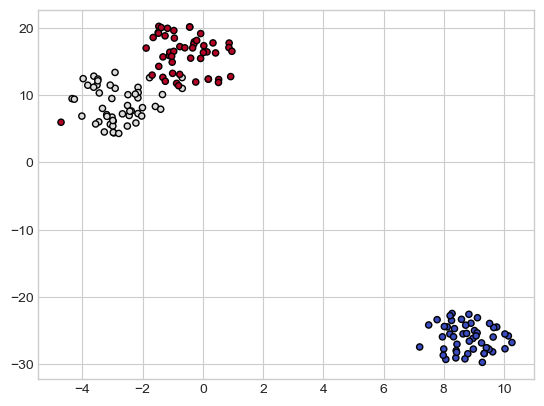

In [20]:
plt.scatter(X_comp[:,0], X_comp[:,1],
           c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [21]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


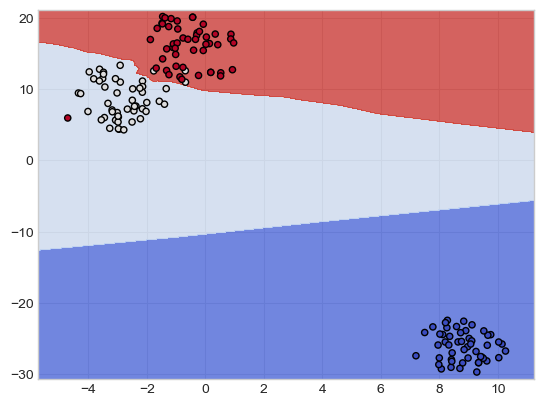

In [22]:
xx,yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

### 유방암 데이터

In [23]:
cancer = load_breast_cancer()

In [24]:
cancer_df = pd.DataFrame(data=cancer.data, columns = cancer.feature_names)
cancer_df['target'] = cancer.target
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [25]:
X, y =cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=121)

In [68]:
#데이터가 훈련데이터로 어떻게 나뉘어 지는지 한 번 보기(단순한 궁금증)
cancer_train_df = pd.DataFrame(data=X_train, columns=cancer.feature_names)
cancer_train_df['target'] = y_train #훈련데이터의 target은 무엇? 당연히 X의 target은 y인것 처럼 y_train이 됨
cancer_train_df
# 569개의 행(데이터)에서 455개만 들어왔다

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,19.53,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.10620,0.1792,0.06552,...,26.24,171.10,2053.0,0.14950,0.41160,0.6121,0.19800,0.2968,0.09929,0
1,15.73,11.28,102.80,747.2,0.10430,0.12990,0.11910,0.06211,0.1784,0.06259,...,14.20,112.50,854.3,0.15410,0.29790,0.4004,0.14520,0.2557,0.08181,1
2,9.72,18.22,60.73,288.1,0.06950,0.02344,0.00000,0.00000,0.1653,0.06447,...,20.83,62.25,303.8,0.07117,0.02729,0.0000,0.00000,0.1909,0.06559,1
3,17.46,39.28,113.40,920.6,0.09812,0.12980,0.14170,0.08811,0.1809,0.05966,...,44.87,141.20,1408.0,0.13650,0.37350,0.3241,0.20660,0.2853,0.08496,0
4,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,0.05425,...,26.36,139.20,1410.0,0.12340,0.24450,0.3538,0.15710,0.3206,0.06938,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,...,27.95,102.80,759.4,0.17860,0.41660,0.5006,0.20880,0.3900,0.11790,0
451,13.81,23.75,91.56,597.8,0.13230,0.17680,0.15580,0.09176,0.2251,0.07421,...,41.85,128.50,1153.0,0.22260,0.52090,0.4646,0.20130,0.4432,0.10860,0
452,16.13,17.88,107.00,807.2,0.10400,0.15590,0.13540,0.07752,0.1998,0.06515,...,27.26,132.70,1261.0,0.14460,0.58040,0.5274,0.18640,0.4270,0.12330,0
453,13.14,20.74,85.98,536.9,0.08675,0.10890,0.10850,0.03510,0.1562,0.06020,...,25.46,100.90,689.1,0.13510,0.35490,0.4504,0.11810,0.2563,0.08174,1


In [69]:
cancer_test_df = pd.DataFrame(data=X_test, columns=cancer.feature_names)
cancer_test_df['target'] = y_test
cancer_test_df # 위의 455개의 데이터를 보고 테스트 데이터가 제대로 된 타겟값을 갖게 되는지 확인

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,9.029,17.33,58.79,250.5,0.10660,0.14130,0.313000,0.043750,0.2111,0.08046,...,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750,1
1,10.650,25.22,68.01,347.0,0.09657,0.07234,0.023790,0.016150,0.1897,0.06329,...,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147,1
2,23.210,26.97,153.50,1670.0,0.09509,0.16820,0.195000,0.123700,0.1909,0.06309,...,34.51,206.00,2944.0,0.14810,0.41260,0.58200,0.25930,0.3103,0.08677,0
3,27.420,26.27,186.90,2501.0,0.10840,0.19880,0.363500,0.168900,0.2061,0.05623,...,31.37,251.20,4254.0,0.13570,0.42560,0.68330,0.26250,0.2641,0.07427,0
4,12.300,19.02,77.88,464.4,0.08313,0.04202,0.007756,0.008535,0.1539,0.05945,...,28.46,84.53,544.3,0.12220,0.09052,0.03619,0.03983,0.2554,0.07207,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,10.260,14.71,66.20,321.6,0.09882,0.09159,0.035810,0.020370,0.1633,0.07005,...,19.48,70.89,357.1,0.13600,0.16360,0.07162,0.04074,0.2434,0.08488,1
110,18.080,21.84,117.40,1024.0,0.07371,0.08642,0.110300,0.057780,0.1770,0.05340,...,24.70,129.10,1228.0,0.08822,0.19630,0.25350,0.09181,0.2369,0.06558,0
111,12.450,15.70,82.57,477.1,0.12780,0.17000,0.157800,0.080890,0.2087,0.07613,...,23.75,103.40,741.6,0.17910,0.52490,0.53550,0.17410,0.3985,0.12440,0
112,14.250,21.72,93.63,633.0,0.09823,0.10980,0.131900,0.055980,0.1885,0.06125,...,30.36,116.20,799.6,0.14460,0.42380,0.51860,0.14470,0.3591,0.10140,0


In [26]:
scaler = GaussRankScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [27]:
model = KNeighborsClassifier()
model.fit(X_train, y_train) #scale 스케일링(전처리) 안한 상태의 데이터로 최근접 모델을 적용했을때 밑에 점수

KNeighborsClassifier()

In [28]:
print(f'학습 데이터 점수 : {model.score(X_train, y_train)}')
print(f'평가 데이터 점수 : {model.score(X_test, y_test)}')

학습 데이터 점수 : 0.945054945054945
평가 데이터 점수 : 0.9473684210526315


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [31]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train) #scale을 통해서 스케일링을 한 이후 최근접 모델을 적용했을때

KNeighborsClassifier()

In [32]:
print(f'학습 데이터 점수 : {model.score(X_train_scale, y_train)}')
print(f'평가 데이터 점수 : {model.score(X_test_scale, y_test)}')

학습 데이터 점수 : 0.978021978021978
평가 데이터 점수 : 0.9824561403508771


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [33]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [34]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00498676, 0.00398946, 0.00298882, 0.00299311, 0.00324631]),
 'score_time': array([0.01307654, 0.01097131, 0.01318645, 0.01108027, 0.00994015]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [35]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())]
)

In [36]:
param_grid = [{'model__n_neighbors' : [3,5,7],
              'model__weights' : ['uniform', 'distance'],
              'model__algorithm': ['ball tree', 'kd_tree', 'brute']}]

In [37]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [38]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, y)
  File "C:\Users\User\anacond

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [39]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7))])

In [40]:
print(f'GridSearchCV best score : {gs.best_score_}')

GridSearchCV best score : 0.9701288619779538


In [41]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [42]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target'] = y #y는 target값
cancer_comp_df

,0,1,target
0,12.127902,-26.100779,0
1,10.140066,-24.281488,0
2,12.610426,-20.140781,0
3,-18.597315,8.759957,0
4,14.946448,-19.855858,0
...,...,...,...
564,8.609241,-24.962320,0
565,12.704230,-21.248770,0
566,21.000166,-4.120015,0
567,11.756538,-22.815134,0


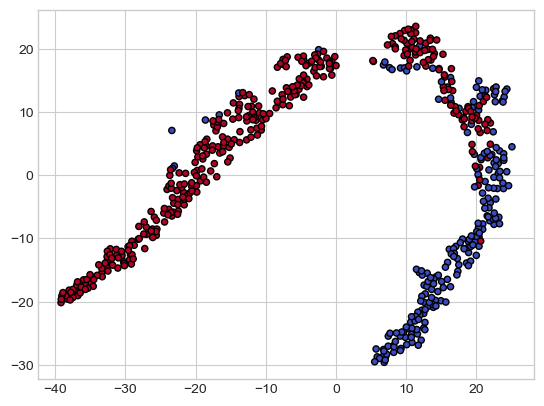

In [43]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k') # c=y를 통해서 타겟값에 따라 색을 줌



In [44]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


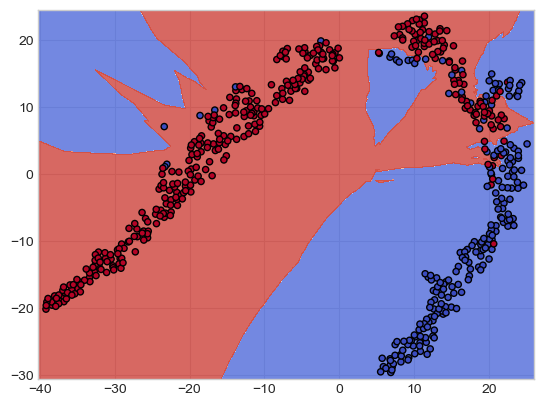

In [45]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8) #alpha 투명값
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k')

In [75]:
wine = load_wine()

In [76]:
wine_df = pd.DataFrame(data=wine.data, columns = wine.feature_names)
wine_df['target'] = wine.target
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [77]:
X, y =wine.data, wine.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [78]:
#데이터가 훈련데이터로 어떻게 나뉘어 지는지 한 번 보기(단순한 궁금증)
wine_train_df = pd.DataFrame(data=X_train, columns=wine.feature_names)
wine_train_df['target'] = y_train #훈련데이터의 target은 무엇? 당연히 X의 target은 y인것 처럼 y_train이 됨
wine_train_df
# 569개의 행(데이터)에서 455개만 들어왔다

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.50,3.12,2.62,24.0,123.0,1.40,1.57,0.22,1.25,8.60,0.59,1.30,500.0,2
1,13.86,1.51,2.67,25.0,86.0,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410.0,1
2,14.30,1.92,2.72,20.0,120.0,2.80,3.14,0.33,1.97,6.20,1.07,2.65,1280.0,0
3,14.22,1.70,2.30,16.3,118.0,3.20,3.00,0.26,2.03,6.38,0.94,3.31,970.0,0
4,11.82,1.72,1.88,19.5,86.0,2.50,1.64,0.37,1.42,2.06,0.94,2.44,415.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,13.50,1.81,2.61,20.0,96.0,2.53,2.61,0.28,1.66,3.52,1.12,3.82,845.0,0
138,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937.0,1
139,14.02,1.68,2.21,16.0,96.0,2.65,2.33,0.26,1.98,4.70,1.04,3.59,1035.0,0
140,13.36,2.56,2.35,20.0,89.0,1.40,0.50,0.37,0.64,5.60,0.70,2.47,780.0,2


In [79]:
wine_test_df = pd.DataFrame(data=X_test, columns=wine.feature_names)
wine_test_df['target'] = y_test
wine_test_df # 위의 455개의 데이터를 보고 테스트 데이터가 제대로 된 타겟값을 갖게 되는지 확인

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.75,1.73,2.41,16.0,89.0,2.60,2.76,0.29,1.81,5.60,1.15,2.90,1320.0,0
1,12.79,2.67,2.48,22.0,112.0,1.48,1.36,0.24,1.26,10.80,0.48,1.47,480.0,2
2,12.84,2.96,2.61,24.0,101.0,2.32,0.60,0.53,0.81,4.92,0.89,2.15,590.0,2
3,13.16,3.57,2.15,21.0,102.0,1.50,0.55,0.43,1.30,4.00,0.60,1.68,830.0,2
4,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0,0
5,12.00,3.43,2.00,19.0,87.0,2.00,1.64,0.37,1.87,1.28,0.93,3.05,564.0,1
6,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
7,12.36,3.83,2.38,21.0,88.0,2.30,0.92,0.50,1.04,7.65,0.56,1.58,520.0,2
8,13.49,3.59,2.19,19.5,88.0,1.62,0.48,0.58,0.88,5.70,0.81,1.82,580.0,2
9,14.10,2.16,2.30,18.0,105.0,2.95,3.32,0.22,2.38,5.75,1.25,3.17,1510.0,0


In [80]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [81]:
model = KNeighborsClassifier()
model.fit(X_train, y_train) #scale 스케일링(전처리) 안한 상태의 데이터로 최근접 모델을 적용했을때 밑에 점수

KNeighborsClassifier()

In [82]:
print(f'학습 데이터 점수 : {model.score(X_train, y_train)}')
print(f'평가 데이터 점수 : {model.score(X_test, y_test)}')

학습 데이터 점수 : 0.823943661971831
평가 데이터 점수 : 0.6388888888888888


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [83]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train) #scale을 통해서 스케일링(전처리)을 한 이후 최근접 모델을 적용했을때 밑의 점수

KNeighborsClassifier()

In [85]:
print(f'학습 데이터 점수 : {model.score(X_train_scale, y_train)}')
print(f'평가 데이터 점수 : {model.score(X_test_scale, y_test)}')

학습 데이터 점수 : 0.9788732394366197
평가 데이터 점수 : 0.9722222222222222


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [86]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [87]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    3.1s finished


{'fit_time': array([0.00299096, 0.00354981, 0.00320721, 0.00340891, 0.00199318]),
 'score_time': array([0.00498724, 0.00443482, 0.00544095, 0.00407505, 0.00398946]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

In [88]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())]
)

In [89]:
param_grid = [{'model__n_neighbors' : [3,5,7],
              'model__weights' : ['uniform', 'distance'],
              'model__algorithm': ['ball tree', 'kd_tree', 'brute']}]

In [90]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [91]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, y)
  File "C:\Users\User\anacond

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [92]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7))])

In [93]:
print(f'GridSearchCV best score : {gs.best_score_}')

GridSearchCV best score : 0.9665079365079364


In [94]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [42]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target'] = y #y는 target값
cancer_comp_df

,0,1,target
0,12.127902,-26.100779,0
1,10.140066,-24.281488,0
2,12.610426,-20.140781,0
3,-18.597315,8.759957,0
4,14.946448,-19.855858,0
...,...,...,...
564,8.609241,-24.962320,0
565,12.704230,-21.248770,0
566,21.000166,-4.120015,0
567,11.756538,-22.815134,0


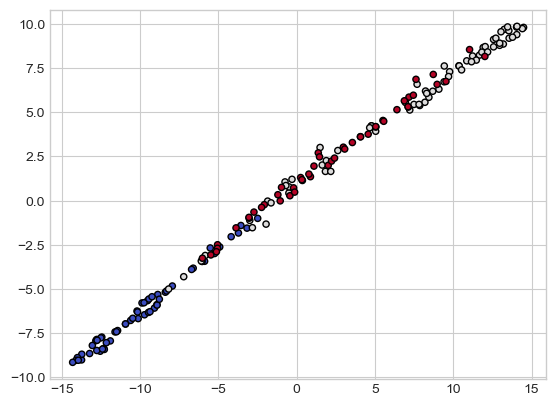

In [95]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k') # c=y를 통해서 타겟값에 따라 색을 줌



In [96]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


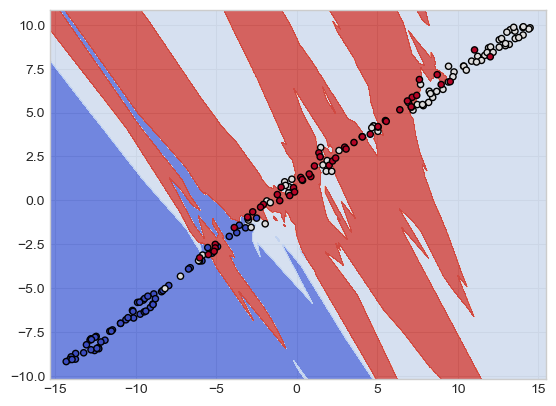

In [97]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8) #alpha 투명값
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolor='k')

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [98]:
boston = load_boston()

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i

In [99]:
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
boston_df['Target'] = boston.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [123]:
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [107]:
boston_train_df = pd.DataFrame(data=X_train, columns=boston.feature_names)
boston_train_df['TARGET'] = y_train
boston_train_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,11.10810,0.0,18.10,0.0,0.668,4.906,100.0,1.1742,24.0,666.0,20.2,396.90,34.77,13.8
1,5.66637,0.0,18.10,0.0,0.740,6.219,100.0,2.0048,24.0,666.0,20.2,395.69,16.59,18.4
2,0.11027,25.0,5.13,0.0,0.453,6.456,67.8,7.2255,8.0,284.0,19.7,396.90,6.73,22.2
3,4.54192,0.0,18.10,0.0,0.770,6.398,88.0,2.5182,24.0,666.0,20.2,374.56,7.79,25.0
4,0.01709,90.0,2.02,0.0,0.410,6.728,36.1,12.1265,5.0,187.0,17.0,384.46,4.50,30.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
400,0.05302,0.0,3.41,0.0,0.489,7.079,63.1,3.4145,2.0,270.0,17.8,396.06,5.70,28.7
401,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
402,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3


In [108]:
boston_test_df = pd.DataFrame(data=X_test, columns=boston.feature_names)
boston_test_df['TARGET'] = y_test
boston_test_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.09252,30.0,4.93,0.0,0.428,6.606,42.2,6.1899,6.0,300.0,16.6,383.78,7.37,23.3
1,0.21719,0.0,10.59,1.0,0.489,5.807,53.8,3.6526,4.0,277.0,18.6,390.94,16.03,22.4
2,7.75223,0.0,18.10,0.0,0.713,6.301,83.7,2.7831,24.0,666.0,20.2,272.21,16.23,14.9
3,5.82401,0.0,18.10,0.0,0.532,6.242,64.7,3.4242,24.0,666.0,20.2,396.90,10.74,23.0
4,0.01538,90.0,3.75,0.0,0.394,7.454,34.2,6.3361,3.0,244.0,15.9,386.34,3.11,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,20.08490,0.0,18.10,0.0,0.700,4.368,91.2,1.4395,24.0,666.0,20.2,285.83,30.63,8.8
98,0.03306,0.0,5.19,0.0,0.515,6.059,37.3,4.8122,5.0,224.0,20.2,396.14,8.51,20.6
99,0.59005,0.0,21.89,0.0,0.624,6.372,97.9,2.3274,4.0,437.0,21.2,385.76,11.12,23.0
100,18.08460,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05,7.2


In [124]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [127]:
#전처리 안 한 결과값 (전처리 안한 값을 model fit로 적용)
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [128]:
#전처리 안 한 결과값
print(f'학습데이터 점수 : {model.score(X_train, y_train)}')
print(f'평가데이터 점수 : {model.score(X_test, y_test)}')

학습데이터 점수 : 0.688010097034595
평가데이터 점수 : 0.5924595954432517


In [129]:
#전처리 후 결과값 (전처리 값을 model fit로 적용)
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [130]:
#전처리 후 결과값
print(f'학습데이터 점수 : {model.score(X_train_scale, y_train)}')
print(f'평가데이터 점수 : {model.score(X_test_scale, y_test)}')

학습데이터 점수 : 0.8503200880816606
평가데이터 점수 : 0.7207742389800303


In [135]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [136]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00299382, 0.00290704, 0.00301623, 0.00298715, 0.0029974 ]),
 'score_time': array([0.00298715, 0.00324774, 0.00299358, 0.00199628, 0.00099611]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [137]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())]
)

In [138]:
param_grid = [{'model__n_neighbors' : [3,5,7],
              'model__weights' : ['uniform', 'distance'],
              'model__algorithm': ['ball tree', 'kd_tree', 'brute']}]

In [139]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [140]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py", line 213, in fit
    return self._fit(X, y)
  File "C:\Users\User\anaconda3\l

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [141]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='kd_tree', n_neighbors=7,
                                     weights='distance'))])

In [142]:
print(f'GridSearchCV best score : {gs.best_score_}')

GridSearchCV best score : 0.4973060611762845


In [146]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [147]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['target'] = y #y는 target값
boston_comp_df

,0,target
0,14.059384,24.0
1,39.239128,21.6
2,35.502567,34.7
3,36.448608,33.4
4,36.707394,36.2
...,...,...
501,21.540855,22.4
502,22.191525,20.6
503,22.981907,23.9
504,22.936140,22.0


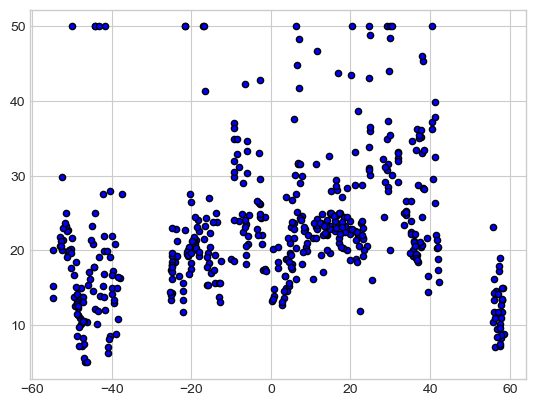

In [148]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k') # c=y를 통해서 타겟값에 따라 색을 줌



In [149]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

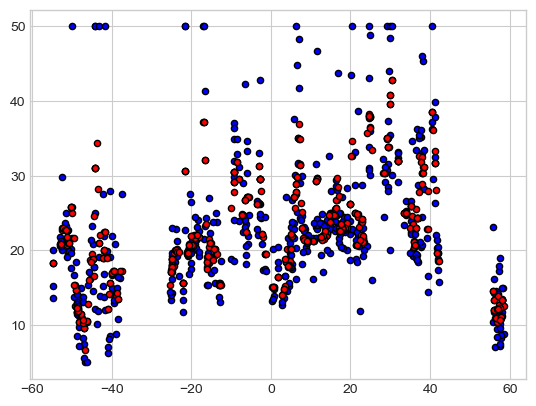

In [151]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k')

### 캘리포니아 주택 가격 데이터

In [157]:
california = fetch_california_housing()

In [158]:
california_df = pd.DataFrame(data=california.data, columns=california.feature_names)
california_df['Target'] = california.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [159]:
X, y = california.data, california.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [160]:
california_train_df = pd.DataFrame(data=X_train, columns=california.feature_names)
california_train_df['TARGET'] = y_train
california_train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,2.5737,46.0,5.528796,1.219895,1249.0,3.269634,38.02,-121.88,0.870
1,3.2011,48.0,4.941463,0.946341,464.0,2.263415,37.78,-122.45,4.283
2,4.5625,20.0,6.202198,1.052747,1372.0,3.015385,36.78,-119.53,1.369
3,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98,1.375
4,6.0191,8.0,6.347327,1.047525,15507.0,3.070693,34.03,-117.78,2.539
...,...,...,...,...,...,...,...,...,...
16507,1.6089,19.0,2.008734,1.052402,890.0,3.886463,34.04,-118.28,1.625
16508,2.6087,21.0,5.193029,1.042895,1002.0,2.686327,37.25,-121.00,0.962
16509,4.2132,2.0,6.200306,1.123853,1730.0,2.645260,36.83,-119.88,0.965
16510,2.6576,23.0,5.163004,1.120879,1644.0,3.010989,38.44,-122.74,1.479


In [161]:
california_test_df = pd.DataFrame(data=X_test, columns=california.feature_names)
california_test_df['TARGET'] = y_test
california_test_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,1.9750,30.0,4.808917,1.087049,1402.0,2.976645,34.65,-120.44,1.34000
1,2.1429,38.0,3.740406,1.054176,2033.0,4.589165,33.97,-118.24,1.18500
2,2.0184,20.0,6.729592,1.576531,486.0,2.479592,34.66,-117.50,0.84900
3,3.2708,43.0,4.188571,0.925714,497.0,2.840000,37.47,-122.21,2.55300
4,5.0887,46.0,5.797115,0.985573,2535.0,2.285843,37.74,-122.45,3.35100
...,...,...,...,...,...,...,...,...,...
4123,4.2348,25.0,6.020352,1.051804,3259.0,3.014801,37.99,-122.31,1.57800
4124,3.5573,21.0,4.104494,1.074157,1510.0,1.696629,34.07,-118.38,5.00001
4125,3.6201,21.0,4.666220,1.083110,1866.0,2.501340,34.11,-117.81,1.50400
4126,2.6548,27.0,3.443396,1.069182,1300.0,4.088050,33.98,-118.22,1.23200


In [162]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [163]:
#전처리 안 한 결과값 (전처리 안한 값을 model fit로 적용)
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [164]:
#전처리 안 한 결과값
print(f'학습데이터 점수 : {model.score(X_train, y_train)}')
print(f'평가데이터 점수 : {model.score(X_test, y_test)}')

학습데이터 점수 : 0.4517637229097621
평가데이터 점수 : 0.14761826726200467


In [165]:
#전처리 후 결과값 (전처리 값을 model fit로 적용)
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [166]:
#전처리 후 결과값
print(f'학습데이터 점수 : {model.score(X_train_scale, y_train)}')
print(f'평가데이터 점수 : {model.score(X_test_scale, y_test)}')

학습데이터 점수 : 0.794614528666967
평가데이터 점수 : 0.6758068565493129


In [167]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [168]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    3.8s finished


{'fit_time': array([0.06353283, 0.06552744, 0.08199334, 0.06452942, 0.06353259]),
 'score_time': array([0.55638814, 0.42298532, 0.45113206, 0.60362482, 0.518116  ]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [169]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())]
)

In [170]:
param_grid = [{'model__n_neighbors' : [3,5,7],
              'model__weights' : ['uniform', 'distance'],
              'model__algorithm': ['ball tree', 'kd_tree', 'brute']}]

In [171]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [172]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py", line 213, in fit
    return self._fit(X, y)
  File "C:\Users\User\anaconda3\l

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [174]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='kd_tree', n_neighbors=7,
                                     weights='distance'))])

In [175]:
print(f'GridSearchCV best score : {gs.best_score_}')

GridSearchCV best score : 0.5376515274379832


In [176]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [178]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['target'] = y #y는 target값
boston_comp_df

,0,target
0,-58.637772,4.526
1,-89.544258,3.585
2,-42.449051,3.521
3,-20.743948,3.413
4,-20.354670,3.422
...,...,...
20635,-61.614208,0.781
20636,-83.485115,0.771
20637,-24.263521,0.923
20638,-33.602592,0.847


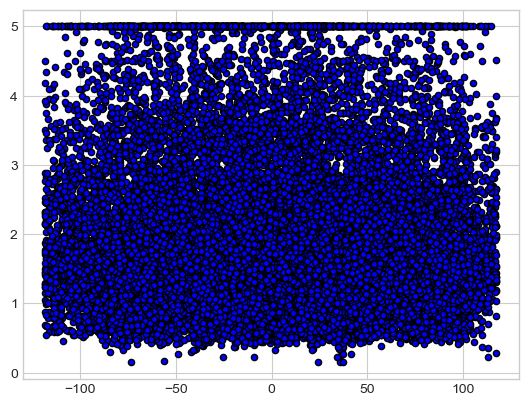

In [179]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k') # c=y를 통해서 타겟값에 따라 색을 줌



In [180]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

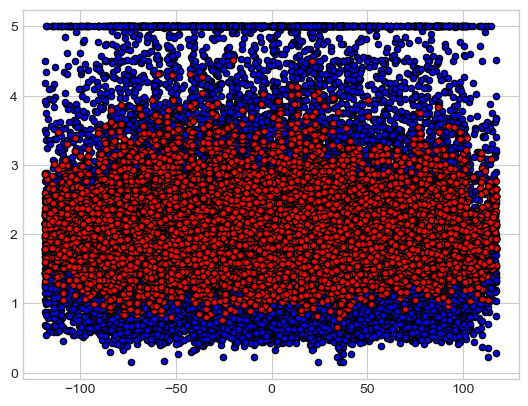

In [181]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [44]:
def a(x,y,z):
    a = x + 2
    b = y + 3
    c = z + 4
    return a,b,c

q,w,e = a(1,1,1)
print(q,w,e)



3 4 5
